In [1]:
import pickle as pkl
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import product
from scipy import sparse
import networkx as nx

# Data loading

In [2]:
#Load the result files in the same manner as in Results-boxplots.ipynb
def get_timestamp(filen):
    filen = filen.replace('_','').replace('-','')
    return filen[-16:-4]

#Load the data
results = []
#Change this to wherever you have the data
PATH = "../Data/results/all_results/"
for filen in glob(PATH + "**/*.pkl",recursive=True):
    #Ignore the config files
    if filen[-10:]!='config.pkl':
        with open(filen, 'rb') as file:
            item = pkl.load(file)
            item['filename'] = filen
            item['timestamp'] = get_timestamp(filen)
            results.append(item)

#Sort by timestamp, break ties alphabetically by experiment name
results.sort(key=lambda item:(item['timestamp']+' '.join(item['experiment'])))
for i in range(len(results)):
    results[i]['id']=i

In [3]:
def get_opt_data(index):
    """Gets the optimization data of the experiment in the list `results` corresponding to the given index"""
    opt_filename = results[index]['filename']
    split_index = max(opt_filename.rfind('/'), opt_filename.rfind('\\'))
    if split_index < 0:
        raise ValueError("invalid filepath")
    filename = opt_filename[:split_index+1] + 'results.csv'
    return load_opt_data(filename)
    
    
def load_opt_data(filename):
    """Loads the optimization data from a results.csv file with the given filename"""
    df = pd.read_csv(filename, index_col='Trial-ID')
    return df

## Mean degree of optimized parameters

In [13]:
max_list = [10, 12, 6, 8, 3, 55, 57, 58, 59, 30,28,45,1, 38,48,51, 35,39,32]
for i in max_list:
    r = results[i]
    print('#{}\t\t\t\t\t\t ({})'.format(i, r['experiment']))
    print('\t mean_degree: {}'.format(r['opt_parameters']['mean_degree']))
    print('\t spect_rad: {}'.format(r['opt_parameters']['spect_rad']))

#10						 (('lorenz', 'random', 'continue', 'augmented'))
	 mean_degree: 4.761101334480012
	 spect_rad: 14.808519004393276
#12						 (('lorenz', 'random', 'random', 'augmented'))
	 mean_degree: 0.16429707771256064
	 spect_rad: 8.430720726514366
#6						 (('lorenz', 'activ_f', 'continue', 'augmented'))
	 mean_degree: 5.0
	 spect_rad: 13.952793328797163
#8						 (('lorenz', 'activ_f', 'random', 'augmented'))
	 mean_degree: 5.0
	 spect_rad: 19.64735209662313
#3						 (('lorenz', 'relax', 'continue', 'augmented'))
	 mean_degree: 4.0281082448338195
	 spect_rad: 0.1
#55						 (('rossler', 'random', 'continue', 'standard'))
	 mean_degree: 2.9579733547588765
	 spect_rad: 10.982317350233373
#57						 (('rossler', 'activ_f', 'continue', 'augmented'))
	 mean_degree: 2.1813147044126664
	 spect_rad: 8.883409264601484
#58						 (('rossler', 'activ_f', 'continue', 'standard'))
	 mean_degree: 2.03490756365901
	 spect_rad: 7.745620211382241
#59						 (('rossler', 'activ_f', 'random', 'augmented'))
	 me

In [14]:
print(results[45]['opt_parameters'])

{'sigma': 1.1433387142699953, 'gamma': 12.101591622895805, 'ridge_alpha': 8.631513359918207e-05, 'spect_rad': 11.89032219020475, 'mean_degree': 0.42057901841348283, 'window': 5.408664556652771, 'overlap': 0.3}


## Thomas-Activ_f-Random-Augmented
Best for Thomas-random prediction

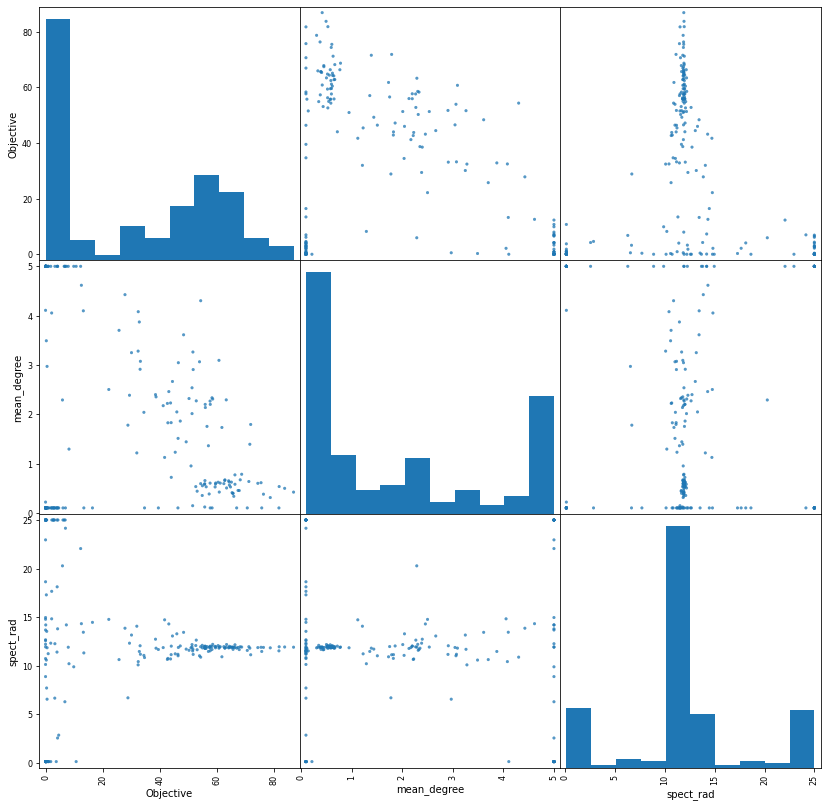

Optimized parameters: {'sigma': 1.1433387142699953, 'gamma': 12.101591622895805, 'ridge_alpha': 8.631513359918207e-05, 'spect_rad': 11.89032219020475, 'mean_degree': 0.42057901841348283, 'window': 5.408664556652771, 'overlap': 0.3}


In [20]:
opt_df = get_opt_data(45)
pd.plotting.scatter_matrix(opt_df[['Objective','mean_degree','spect_rad']], figsize=(14,14))
plt.show()
print('Optimized parameters:', results[45]['opt_parameters'])

## Rossler-Activ_f-Random-Augmented
Best for Rossler-random prediction

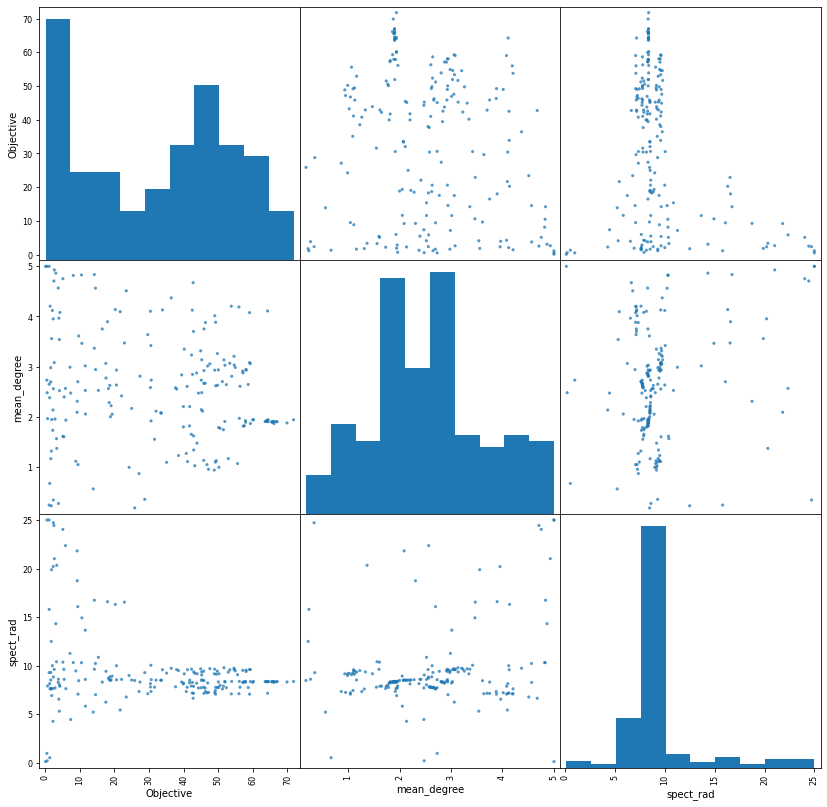

Optimized parameters: {'sigma': 0.43999417116487155, 'gamma': 14.717874767389663, 'ridge_alpha': 6.419188731683075e-05, 'spect_rad': 8.36057608565502, 'mean_degree': 1.9391160743944356, 'window': 3.5114121765558712, 'overlap': 0.9}


In [22]:
opt_df = get_opt_data(59)
pd.plotting.scatter_matrix(opt_df[['Objective','mean_degree','spect_rad']], figsize=(14,14))
plt.show()
print('Optimized parameters:', results[59]['opt_parameters'])

## Rossler-random-continue-standard
Best for Rossler-continue predictions

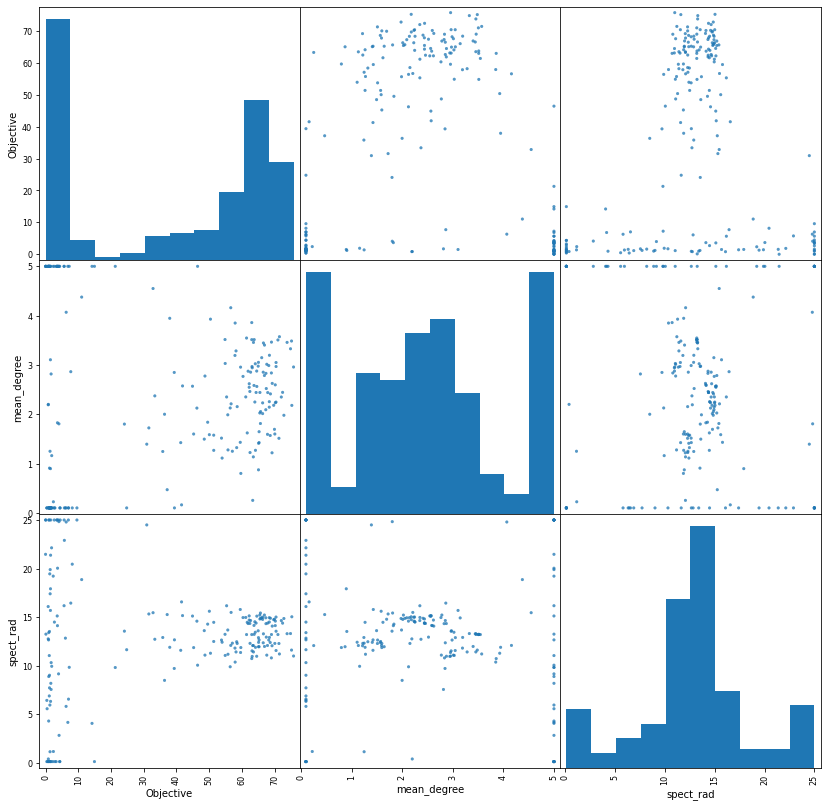

Optimized parameters: {'sigma': 0.9034194184494522, 'gamma': 5.149148076833503, 'ridge_alpha': 3.780103364855963e-06, 'spect_rad': 10.982317350233373, 'mean_degree': 2.9579733547588765}


In [23]:
opt_df = get_opt_data(55)
pd.plotting.scatter_matrix(opt_df[['Objective','mean_degree','spect_rad']], figsize=(14,14))
plt.show()
print('Optimized parameters:', results[55]['opt_parameters'])

# Reservoir connectivity 
Analyzing how connected the generated reservoir networks are for the `mean_degree` hyperparameters given above.

In [8]:
def random_graph(n,mean_degree):
    """Returns a random n by n graph with edge weights of one and mean degree of (on average) mean_degree.
    This is the algorithm used in ResComp."""
    p = mean_degree / n
    A = sparse.random(n,n, density=p, dtype=float, format="lil", data_rvs=np.ones)
    # Remove self edges
    for i in range(n):
         A[i,i] = 0.0
    # Add one loop to ensure positive spectral radius
    if n > 1:
        A[0, 1] = 1
        A[1, 0] = 1
    return A

In [33]:
A = random_graph(500, 0.42057901841348283)

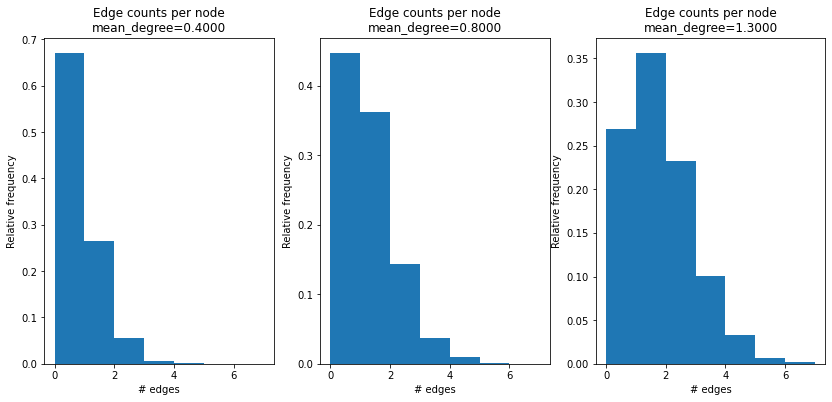

In [9]:
plt.figure(figsize=(14,6))
for i, mean_degree in enumerate([0.4, 0.8, 1.3]):
    plt.subplot(1,3,1+i)
    edge_cts = np.concatenate([np.ravel(random_graph(500, mean_degree).sum(axis=0)) for _ in range(20)])
    mc = np.max(edge_cts)
    plt.hist(edge_cts, density=True, bins=np.arange(0,max(mc,8)))
    plt.title("Edge counts per node\nmean_degree={:.4f}".format(mean_degree))
    plt.xlabel('# edges')
    plt.ylabel('Relative frequency')
plt.show()

In [10]:
def count_connected_components_size(A):
    """Accepts a sparse matrix A, representing a graph's adjacency matrix, and finds the size of all
    of its connected components if it were undirected"""
    graph = nx.Graph(A)
    return [len(c) for c in nx.connected_components(graph)]

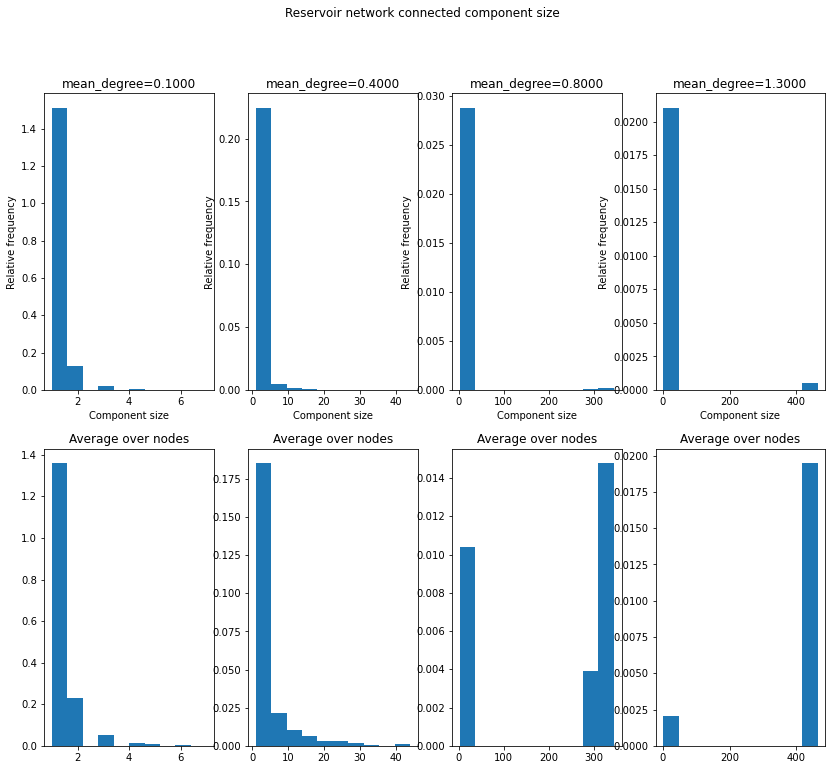

In [12]:
plt.figure(figsize=(14,12))
for i, mean_degree in enumerate([0.1, 0.4, 0.8, 1.3]):
    plt.subplot(2,4,1+i)
    comp_sz = np.concatenate([count_connected_components_size(random_graph(500, mean_degree)) for _ in range(40)])
    mc = np.max(comp_sz)
    plt.hist(comp_sz, density=True)
    plt.title("mean_degree={:.4f}".format(mean_degree))
    plt.xlabel('Component size')
    plt.ylabel('Relative frequency')
    plt.subplot(2,4,5+i)
    plt.hist(comp_sz, density=True, weights=comp_sz)
    plt.title("Average over nodes")
plt.suptitle('Reservoir network connected component size')
plt.show()

In [69]:
[c for c in nx.connected_components(nx.Graph(random_graph(10,0.4)))]

[{0, 1, 4}, {2, 3, 6}, {5}, {7}, {8}, {9}]